In [1]:
#!pip install mlxtend  
#! pip install --index-url https://test.pypi.org/simple/ PyARMViz

In [1]:
#IMPORT PACKAGES

# basics
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from collections import Counter

#scaling
from sklearn.preprocessing import RobustScaler, StandardScaler

#clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette

import datetime as dt

# market basket analysis and visualisation
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict
sns.set()
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18, 18)
style.use('ggplot')


In [2]:
# Import order product dataset
order_prod = pd.read_csv('order_products.csv', usecols=['order_id', 'product_id'])
order_prod.head(2)

,order_id,product_id
0,10,24
1,10,83


In [3]:
#drop the duplicates for orders which have the same product_id more than once
order_prod = order_prod.drop_duplicates(subset=['order_id', 'product_id'], keep='last')

In [4]:
# Import order product dataset
depart = pd.read_csv('departments.csv')
depart.head(2)

,department_id,department
0,1,frozen
1,2,other


In [5]:
# Import product label mapping
products = pd.read_csv('products.csv')
products.head(2)

,product_id,department_id,product_name
0,61,19,cookies cakes
1,104,13,spices seasonings


In [6]:
# Merge product labels
df = pd.merge(order_prod, products, how='left', on='product_id').drop(["product_id", "department_id"], axis=1)

In [7]:
#create df with order_id and department name
data1 = pd.merge(products, depart, how='left', on = 'department_id')
data2 = pd.merge(order_prod,data1, how='left', on = 'product_id')
data_dept = data2[['order_id','department']]

In [8]:
#import orders with all columns
order_full = pd.read_csv('orders.csv',sep=';')
orders = order_full[['order_id','user_id']]
orders.head(2)


,order_id,user_id
0,2425083,49125
1,1944304,162867


In [9]:
#create df with order_id, department and user_id
dept_order = pd.merge(data_dept, orders, how='left', on='order_id')
dept_order.head(2)

,order_id,department,user_id
0,10,produce,135442
1,10,produce,135442


In [10]:
#create df with order_id, product_name and who bought it (user_id)
basket = pd.merge(df, orders, how='left', on='order_id')
basket.head(2)

,order_id,product_name,user_id
0,10,fresh herbs,135442
1,10,fresh fruits,135442


In [11]:
#create a list of the number of orders per user_id (used later in clustering)
no_orders_df = orders.groupby('user_id').count()
no_orders = no_orders_df['order_id'].values.tolist()
no_orders[0:5]

[2, 3, 1, 1, 1]

# Clustering order behaviour (hour, time, days since prior order)

## create df

In [12]:
#pivot to count the count of products
count_prod = order_prod.groupby('order_id').count()
count_prod.reset_index(inplace = True)

In [13]:
#df for orders
data_order = order_full[['order_id','order_dow','order_hour_of_day','days_since_prior_order']]

In [14]:
#create df orders merging the count of products
data_order_df = data_order.merge(count_prod, left_on='order_id', right_on='order_id')
data_order_df['count_product'] = data_order_df['product_id']
data_order_df.drop('product_id', axis = 1, inplace = True)

In [15]:
data_order_df.describe()

,order_id,order_dow,order_hour_of_day,days_since_prior_order,count_product
count,2.000000e+05,200000.000000,200000.000000,187746.000000,200000.000000
mean,1.710075e+06,2.775845,13.458635,10.999989,7.265580
std,9.876437e+05,2.044984,4.220867,9.147087,4.772396
min,1.000000e+01,0.000000,0.000000,0.000000,1.000000
25%,8.532758e+05,1.000000,10.000000,4.000000,4.000000
50%,1.709227e+06,3.000000,13.000000,7.000000,6.000000
75%,2.563077e+06,5.000000,16.000000,15.000000,10.000000
max,3.421080e+06,6.000000,23.000000,30.000000,45.000000


In [16]:
data_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                200000 non-null  int64  
 1   order_dow               200000 non-null  int64  
 2   order_hour_of_day       200000 non-null  int64  
 3   days_since_prior_order  187746 non-null  float64
 4   count_product           200000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 9.2 MB


In [17]:
data_order_df.head(3)

,order_id,order_dow,order_hour_of_day,days_since_prior_order,count_product
0,2425083,2,18,NaN,7
1,1944304,3,17,NaN,7
2,1201011,0,16,3.0,10


## cleaning

In [18]:
#count NA number days since prior order
data_order_df['days_since_prior_order'].isna().sum()

12254

In [19]:
#na filled with mean days since prior order
data_order_df['days_since_prior_order'].fillna(data_order_df['days_since_prior_order'].mean(), inplace = True)

## cluster

In [20]:
order_id_column = data_order_df['order_id']
data_order_df.drop('order_id', axis = 1, inplace = True)

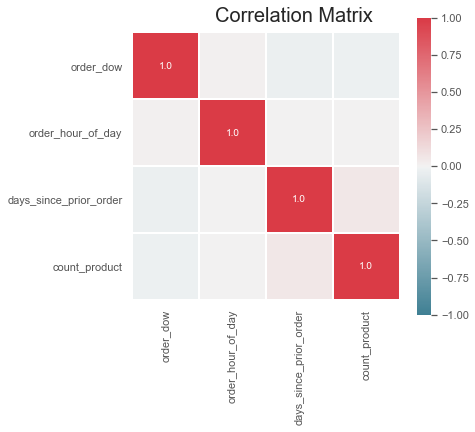

In [21]:
fig = plt.figure(figsize=(6, 5))
# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data_order_df.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.4| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.4
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [22]:
#scale variables for kmeans
scaler = RobustScaler() 
scaled_feat = pd.DataFrame(scaler.fit_transform(data_order_df), columns=data_order_df.columns)
scaled_feat.head(5)

,order_dow,order_hour_of_day,days_since_prior_order,count_product
0,-0.25,0.833333,0.333332,0.166667
1,0.00,0.666667,0.333332,0.166667
2,-0.75,0.500000,-0.555556,0.666667
3,-0.50,-0.333333,-0.555556,-0.166667
4,0.75,-0.333333,-0.222222,0.833333


In [23]:
#kmeans with 50 clusters to decide the number of clusters to use later.
number_clusters = 50
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(scaled_feat)

In [24]:
df_concat = pd.concat((scaled_feat, pd.Series(km_labels, name='labels')), axis=1)
aa = df_concat.groupby('labels').mean()
bb = aa

In [25]:
scaled_feat

,order_dow,order_hour_of_day,days_since_prior_order,count_product
0,-0.25,0.833333,0.333332,0.166667
1,0.00,0.666667,0.333332,0.166667
2,-0.75,0.500000,-0.555556,0.666667
3,-0.50,-0.333333,-0.555556,-0.166667
4,0.75,-0.333333,-0.222222,0.833333
...,...,...,...,...
199995,0.00,-0.833333,0.000000,0.500000
199996,0.75,0.333333,-0.555556,0.833333
199997,0.00,0.000000,1.444444,1.333333
199998,0.00,0.833333,-0.333333,0.166667


In [26]:
def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):

    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

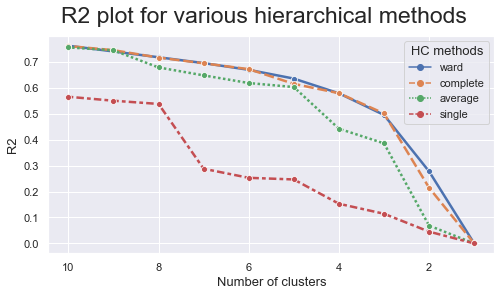

In [27]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Function defined above to obtain the R2 statistic
r2_hc_methods = pd.DataFrame(data=np.concatenate([np.expand_dims(get_r2_hc(df=bb, link=i, max_nclus=10), 1) for i in hc_methods], axis=1),
                             index=range(1,10+1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(8,4))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=23)
plt.gca().invert_xaxis()
plt.legend(title="HC methods", title_fontsize=13)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2", fontsize=13)

plt.show()

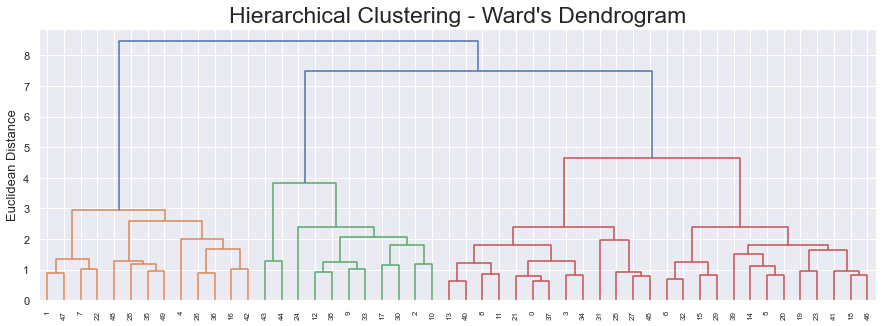

In [28]:
# Hierarchical clustering assessment using scipy
Z = linkage(bb, method="ward")

sns.set()
fig = plt.figure(figsize=(15,5))

# Dendrogram

dendrogram(Z)

plt.hlines(38, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering - Ward\'s Dendrogram', fontsize=23)
plt.ylabel('Euclidean Distance', fontsize=13)
plt.show()

In [29]:
#let's go for 4 clusters
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(scaled_feat)

In [47]:
number_clusters

4

In [30]:
#how many orders per cluster
Counter(km_labels)

Counter({2: 63027, 1: 64491, 3: 34625, 0: 37857})

In [31]:
#create df to export to powerbi to visualise clusters
df_concat = pd.concat((data_order_df, pd.Series(km_labels, name='labels')), axis=1)
aa = df_concat.groupby('labels').mean().round(0).sort_values(by = 'days_since_prior_order')
df_concat_powerbi = pd.concat((df_concat, pd.Series(order_id_column, name='order_id')), axis=1)

In [32]:
df_concat_powerbi.head()

,order_dow,order_hour_of_day,days_since_prior_order,count_product,labels,order_id
0,2,18,10.999989,7,2,2425083
1,3,17,10.999989,7,2,1944304
2,0,16,3.000000,10,2,1201011
3,1,11,3.000000,5,1,1906860
4,6,11,6.000000,11,3,2766469


In [34]:
#evaluate model with R^2
for_R2 = df_concat
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return(ss)

sst = get_ss(for_R2.drop('labels', axis=1))  # get total sum of squares
ssw_labels = for_R2.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
adj=1-((1-r2)*(10000-1)/(10000-len(for_R2.columns)-1))
adj.round(3)

0.645

# Data exploration

In [35]:
# how many departments
depart['department'].unique()

array(['frozen', 'other', 'bakery', 'produce', 'alcohol', 'international',
       'beverages', 'pets', 'dry goods pasta', 'bulk', 'personal care',
       'meat seafood', 'pantry', 'breakfast', 'canned goods',
       'dairy eggs', 'household', 'babies', 'snacks', 'deli', 'missing'],
      dtype=object)

In [36]:
#check the average amount of items per order
count_df = df.groupby('order_id').agg(['count'])
total_orders = len(count_df)
mean_number_item_perorder=count_df['product_name']['count'].sum()/total_orders
mean_number_item_perorder

7.26558

In [37]:
# Get modes and unique values
df.astype(object).describe()

,order_id,product_name
count,1453116,1453116
unique,200000,134
top,45973,fresh fruits
freq,45,111199


In [38]:
# Check product frequencies
df['product_name'].value_counts().head(20)

fresh fruits                     111199
fresh vegetables                  88872
packaged vegetables fruits        73083
yogurt                            52735
milk                              48665
packaged cheese                   46199
water seltzer sparkling water     38601
chips pretzels                    33887
soy lactosefree                   33671
bread                             32773
eggs                              27298
refrigerated                      26808
frozen produce                    24516
crackers                          22994
ice cream ice                     22102
lunch meat                        20778
fresh dips tapenades              19641
fresh herbs                       18601
cereal                            18512
cream                             18321
Name: product_name, dtype: int64

In [39]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Check in how many orders was product fresh fruits sold
pt['fresh fruits'].sum() # more than 55%

111199.0

# Creating association rules 5% support

In [44]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions 
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)

In [45]:
frequent_itemsets

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)
...,...,...
151,0.051295,"(milk, yogurt, packaged vegetables fruits)"
152,0.051915,"(yogurt, packaged cheese, packaged vegetables ..."
153,0.062535,"(milk, packaged vegetables fruits, fresh fruit..."
154,0.068325,"(packaged vegetables fruits, packaged cheese, ..."


In [48]:
# Generate the association rules - by confidence. Finding complementary products with confidence higher than 60%
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.60)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
43,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
85,"(packaged vegetables fruits, yogurt, fresh veg...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,0.027315,3.323711
79,"(milk, packaged vegetables fruits, fresh veget...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,0.021906,3.078336
27,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
82,"(packaged cheese, packaged vegetables fruits, ...",(fresh fruits),0.081970,0.555995,0.068325,0.833537,1.499180,0.022750,2.667284


In [49]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
rulesLift.sort_values(by='lift', ascending=True, inplace=True)
rulesLift.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
110,(water seltzer sparkling water),(fresh vegetables),0.193005,0.444360,0.083355,0.431880,0.971915,-0.002409,0.978033
111,(fresh vegetables),(water seltzer sparkling water),0.444360,0.193005,0.083355,0.187584,0.971915,-0.002409,0.993328
232,"(fresh fruits, fresh vegetables)",(water seltzer sparkling water),0.317560,0.193005,0.063235,0.199128,1.031723,0.001944,1.007645
233,(water seltzer sparkling water),"(fresh fruits, fresh vegetables)",0.193005,0.317560,0.063235,0.327634,1.031723,0.001944,1.014983
82,(water seltzer sparkling water),(fresh fruits),0.193005,0.555995,0.111045,0.575348,1.034807,0.003735,1.045573


In [ ]:
#this analysis didn't show any results, as the minimum lift that we found is 0.97. 
#We will lower the support and check for the lift once again in the paragraph called "Substitute products"

# Creating association rules 2.5% support

In [50]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 2.5% of the transactions 
frequent_itemsets = apriori(pt, min_support=0.025, use_colnames=True)


In [51]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rulesConfidence.sort_values(by='confidence', ascending=True, inplace=True)
rulesConfidence.head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
335,"(lunch meat, packaged vegetables fruits)","(fresh fruits, fresh vegetables)",0.053225,0.317560,0.031940,0.600094,1.889703,0.015038,1.706501
165,"(ice cream ice, fresh fruits)",(fresh vegetables),0.064485,0.444360,0.038700,0.600140,1.350571,0.010045,1.389585
137,"(eggs, fresh vegetables)",(packaged vegetables fruits),0.084310,0.365415,0.050675,0.601056,1.644858,0.019867,1.590660
127,"(dry pasta, fresh vegetables)",(packaged vegetables fruits),0.047235,0.365415,0.028440,0.602096,1.647704,0.011180,1.594819
57,(other creams cheeses),(fresh vegetables),0.086485,0.444360,0.052105,0.602474,1.355825,0.013675,1.397747
227,"(pasta sauce, fresh fruits)",(packaged vegetables fruits),0.042840,0.365415,0.025815,0.602591,1.649059,0.010161,1.596806
257,"(packaged cheese, fresh vegetables)",(packaged vegetables fruits),0.135850,0.365415,0.081970,0.603386,1.651235,0.032328,1.600007
125,"(fresh fruits, dry pasta)",(packaged vegetables fruits),0.048095,0.365415,0.029050,0.604013,1.652950,0.011475,1.602540
397,"(yogurt, packaged cheese, fresh vegetables)","(packaged vegetables fruits, fresh fruits)",0.057195,0.269870,0.034565,0.604336,2.239360,0.019130,1.845329
95,"(canned meals beans, fresh vegetables)",(packaged vegetables fruits),0.050435,0.365415,0.030555,0.605829,1.657921,0.012125,1.609924


# Complementary Products

In [58]:
# High Confidence and high Lift 
rulesConfidence2 = rulesConfidence[(rulesConfidence['confidence'] >= 0.6) & (rulesConfidence['lift'] >= 1.6)]
rulesConfidence2.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence2.head(10)

<ipython-input-58-48f60560be88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rulesConfidence2.sort_values(by='confidence', ascending=False, inplace=True)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
322,"(packaged vegetables fruits, fresh fruits, fre...",(fresh vegetables),0.043490,0.444360,0.039660,0.911934,2.052241,0.020335,6.309343
392,"(milk, packaged vegetables fruits, yogurt, fre...",(fresh fruits),0.036455,0.555995,0.032845,0.900974,1.620471,0.012576,4.483713
396,"(packaged vegetables fruits, yogurt, packaged ...",(fresh fruits),0.038635,0.555995,0.034565,0.894655,1.609106,0.013084,4.214775
239,"(packaged vegetables fruits, fresh herbs)",(fresh vegetables),0.052535,0.444360,0.046980,0.894261,2.012470,0.023636,5.254824
152,"(fresh fruits, fresh herbs)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
240,"(yogurt, fresh herbs)",(fresh vegetables),0.029480,0.444360,0.025975,0.881106,1.982865,0.012875,4.673400
285,"(canned jarred vegetables, packaged vegetables...",(fresh vegetables),0.029740,0.444360,0.026065,0.876429,1.972340,0.012850,4.496526
238,"(packaged cheese, fresh herbs)",(fresh vegetables),0.030290,0.444360,0.026460,0.873556,1.965874,0.013000,4.394343
289,"(packaged vegetables fruits, fresh fruits, can...",(fresh vegetables),0.030560,0.444360,0.025905,0.847677,1.907635,0.012325,3.647768
53,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205


# Substitute Products


In [56]:
rulesLift2 = association_rules(frequent_itemsets, metric="lift", min_threshold=0.0)
rulesLift2.sort_values(by='lift', ascending=True, inplace=True)
rulesLift2.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
345,(fresh vegetables),(soft drinks),0.444360,0.087310,0.027845,0.062663,0.717709,-0.010952,0.973705
344,(soft drinks),(fresh vegetables),0.087310,0.444360,0.027845,0.318921,0.717709,-0.010952,0.815823
275,(fresh fruits),(soft drinks),0.555995,0.087310,0.039585,0.071197,0.815447,-0.008959,0.982652
274,(soft drinks),(fresh fruits),0.087310,0.555995,0.039585,0.453384,0.815447,-0.008959,0.812280
264,(paper goods),(fresh fruits),0.063575,0.555995,0.032090,0.504758,0.907847,-0.003257,0.896542
265,(fresh fruits),(paper goods),0.555995,0.063575,0.032090,0.057716,0.907847,-0.003257,0.993782
66,(fresh vegetables),(candy chocolate),0.444360,0.069305,0.028210,0.063485,0.916017,-0.002586,0.993785
67,(candy chocolate),(fresh vegetables),0.069305,0.444360,0.028210,0.407041,0.916017,-0.002586,0.937064
337,(fresh vegetables),(paper goods),0.444360,0.063575,0.025885,0.058252,0.916277,-0.002365,0.994348
336,(paper goods),(fresh vegetables),0.063575,0.444360,0.025885,0.407157,0.916277,-0.002365,0.937246


# Products that are bought together

In [64]:
#the likelihood of buying the products together is way more than the likelihood of buying the products separated
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1297,"(packaged vegetables fruits, packaged cheese, ...","(yogurt, fresh vegetables)",0.090715,0.144660,0.034565,0.381028,2.633959,0.021442,1.381873
1308,"(yogurt, fresh vegetables)","(packaged vegetables fruits, packaged cheese, ...",0.144660,0.090715,0.034565,0.238940,2.633959,0.021442,1.194761
1268,"(milk, packaged vegetables fruits, fresh fruits)","(yogurt, fresh vegetables)",0.087450,0.144660,0.032845,0.375586,2.596337,0.020194,1.369828
1277,"(yogurt, fresh vegetables)","(milk, packaged vegetables fruits, fresh fruits)",0.144660,0.087450,0.032845,0.227050,2.596337,0.020194,1.180606
1312,"(packaged vegetables fruits, yogurt)","(packaged cheese, fresh fruits, fresh vegetables)",0.127910,0.104570,0.034565,0.270229,2.584193,0.021189,1.227001
1293,"(packaged cheese, fresh fruits, fresh vegetables)","(packaged vegetables fruits, yogurt)",0.104570,0.127910,0.034565,0.330544,2.584193,0.021189,1.302685
1282,"(milk, packaged vegetables fruits)","(yogurt, fresh fruits, fresh vegetables)",0.107425,0.118420,0.032845,0.305748,2.581897,0.020124,1.269827
1263,"(yogurt, fresh fruits, fresh vegetables)","(milk, packaged vegetables fruits)",0.118420,0.107425,0.032845,0.277360,2.581897,0.020124,1.235159
1264,"(milk, fresh fruits, fresh vegetables)","(packaged vegetables fruits, yogurt)",0.099590,0.127910,0.032845,0.329802,2.578393,0.020106,1.301243
1281,"(packaged vegetables fruits, yogurt)","(milk, fresh fruits, fresh vegetables)",0.127910,0.099590,0.032845,0.256782,2.578393,0.020106,1.211502


# Checking the department of different products

In [65]:
print(products[products['product_name']  == 'fresh fruits'])
print(products[products['product_name']  == 'fresh vegetables'])
print(products[products['product_name']  == 'packaged vegetables fruits'])

    product_id  department_id  product_name
81          24              4  fresh fruits
    product_id  department_id      product_name
35          83              4  fresh vegetables
    product_id  department_id                product_name
27         123              4  packaged vegetables fruits


In [66]:
print(products[products['product_name']  == 'yogurt'])
print(products[products['product_name']  == 'packaged cheese'])
print(products[products['product_name']  == 'milk'])

   product_id  department_id product_name
8         120             16       yogurt
    product_id  department_id     product_name
72          21             16  packaged cheese
     product_id  department_id product_name
108          84             16         milk


In [67]:
print(products[products['product_name']  == 'soft drinks'])

    product_id  department_id product_name
54          77              7  soft drinks


In [68]:
print(products[products['product_name']  == 'candy chocolate'])

    product_id  department_id     product_name
74          45             19  candy chocolate


In [69]:
print(products[products['product_name']  == 'paper goods'])

     product_id  department_id product_name
123          54             17  paper goods
